# Exemple sur le modèle jouet Campbell

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [14]:
%reload_ext autoreload
%autoreload 2

import methods_for_scalar_inputs as mfs
import Design_of_experiment as doe

On récupère les entrées

In [26]:
hs_list = np.arange(1, 3.1, 0.5)
msl_list = np.arange(0, 1.1, 0.1)
print(hs_list)
x_train=[]
for hs in hs_list:
    for msl in msl_list:
        x_train.append([hs,msl])
x_train=np.array(x_train)
print("taille de x_train:",x_train.shape)

[1.  1.5 2.  2.5 3. ]
taille de x_train: (55, 2)


In [24]:
base_folder = "config_process_gaussiens/data_malo_GP"

y_train = []

for hs in hs_list:
    for msl in msl_list:

        folder_name = f"run_msl_{msl:.1f}_hs_{hs:.1f}"
        file_path = os.path.join(base_folder, folder_name, "scattered_map_final.bin")

        # Lecture du fichier binaire
        data = np.fromfile(file_path, dtype=np.float32)


        y_train.append(data)

y_train = np.array(y_train)
print("Taille de y_train :", y_train.shape)


Taille de y_train : (55, 2929740)


# IL FAUT METTRE A JOUR NOS FONCTIONS AVEC DE LA POO !

## Méthode par ACP

(200, 5)
Variance expliquée par les 5 premières composantes : [0.77542983 0.13512075 0.03266067 0.0195173  0.01679901]
Variance globale expliquée : 0.9795275725785993
Taille du jeu d'entrainement transformé par ACP : (200, 5)
Affichage des hyperparamètres optimisés

--- Composante principale 1 ---
╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                 │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════════════╡
│ GPR.mean_function.c                │ Parameter │ Identity         │         │ True        │ (1,)    │ float64 │ [151.07792]           │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────────┤
│ GPR.kerne

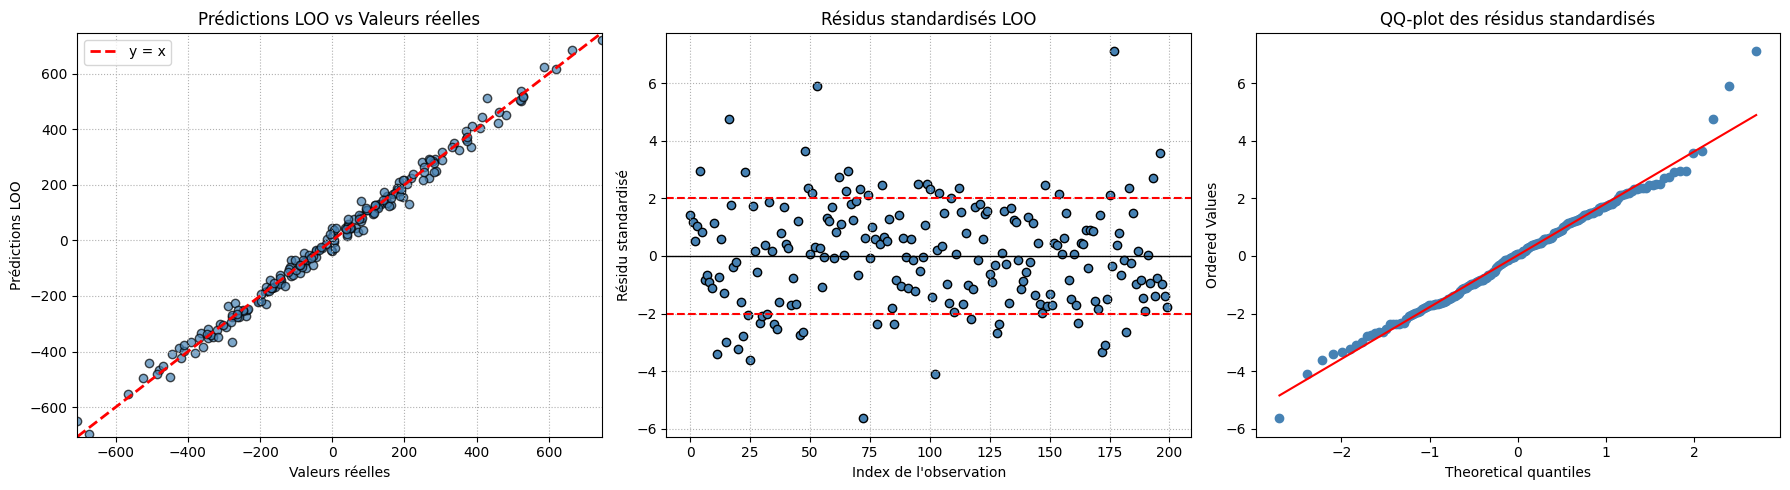

Affichage des hyperparamètres optimisés

--- Composante principale 2 ---
╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                  │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════════════╡
│ GPR.mean_function.c                │ Parameter │ Identity         │         │ True        │ (1,)    │ float64 │ [10.50191]             │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────┤
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 122.94994              │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼

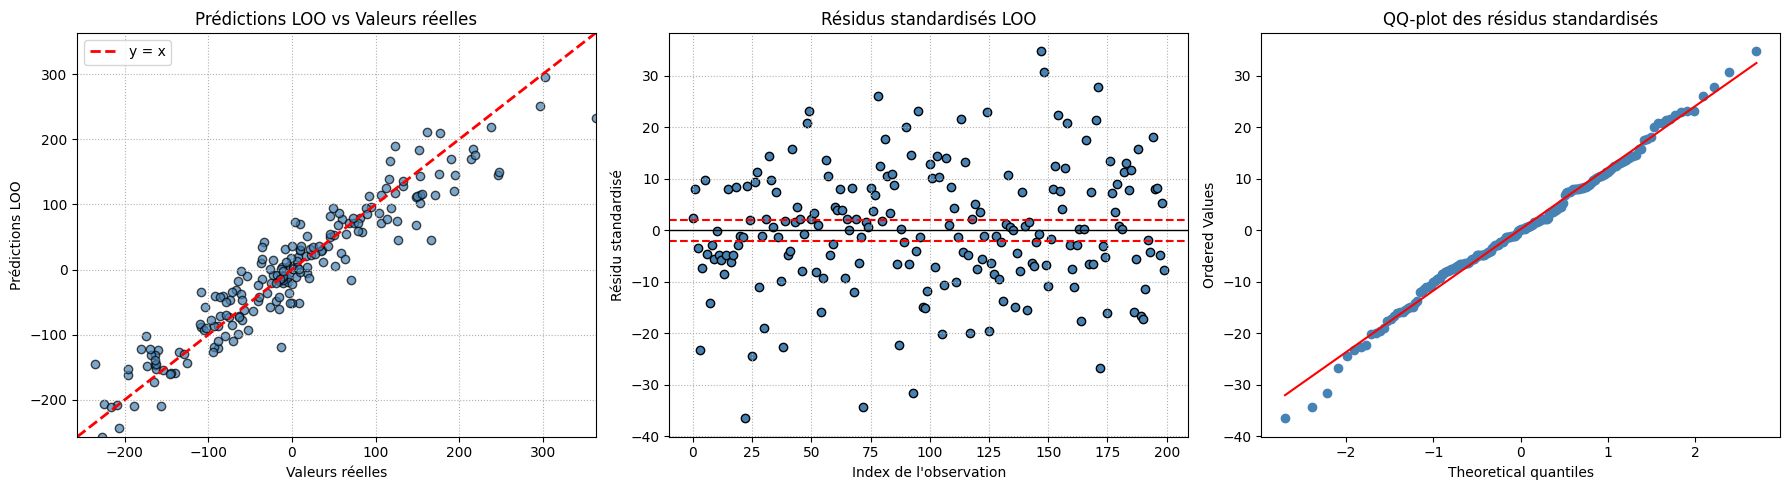

Affichage des hyperparamètres optimisés

--- Composante principale 3 ---
╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                 │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════════════╡
│ GPR.mean_function.c                │ Parameter │ Identity         │         │ True        │ (1,)    │ float64 │ [7.29658]             │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────────┤
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 2862.41735            │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼──────

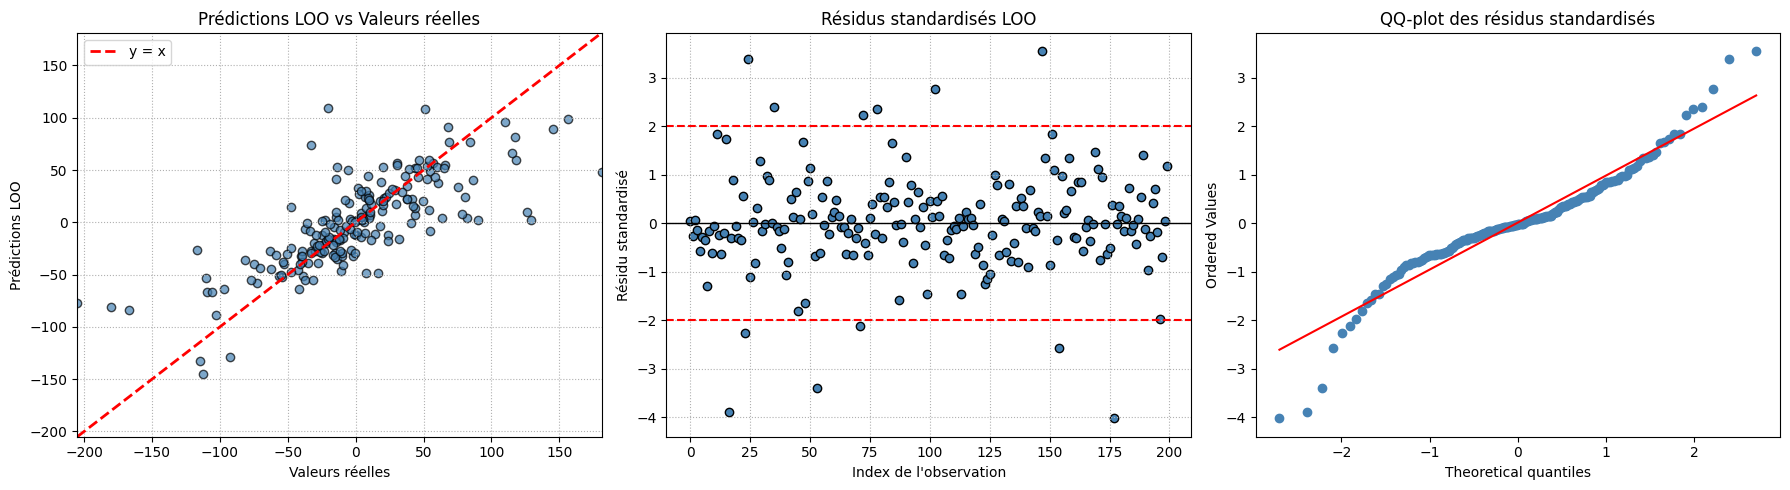

Affichage des hyperparamètres optimisés

--- Composante principale 4 ---
╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                 │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════════════╡
│ GPR.mean_function.c                │ Parameter │ Identity         │         │ True        │ (1,)    │ float64 │ [1.4839]              │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────────┤
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 2418.56211            │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼──────

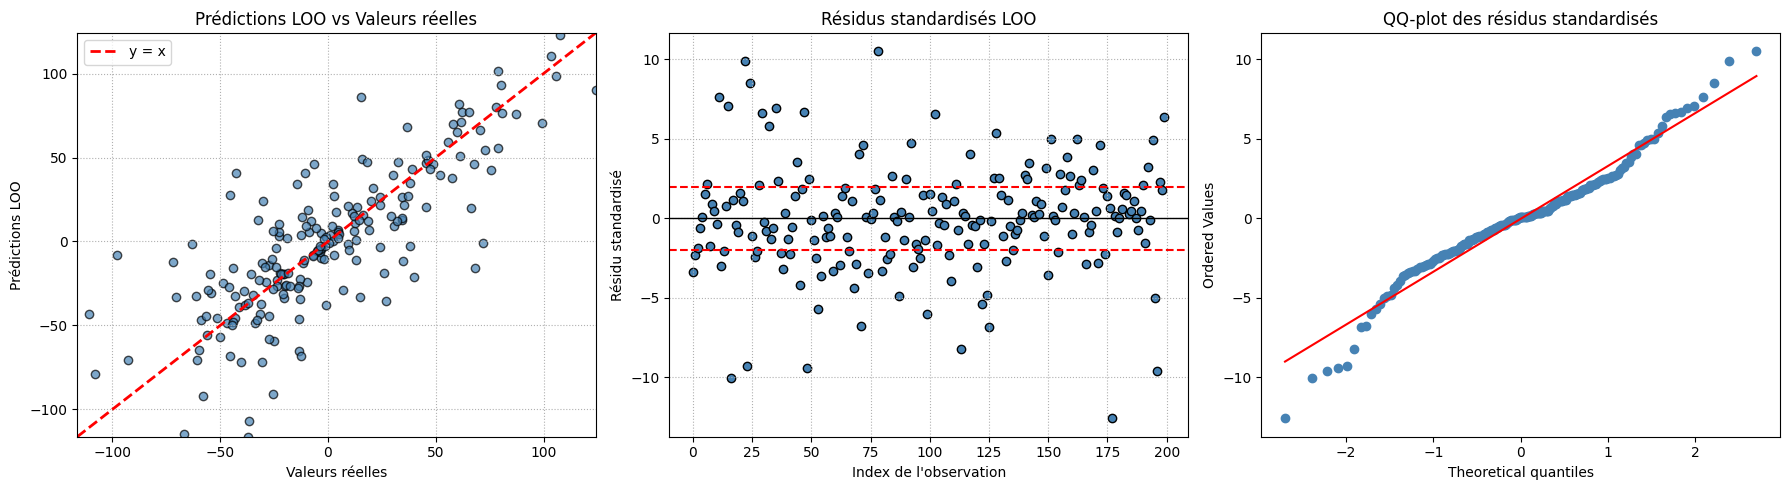

Affichage des hyperparamètres optimisés

--- Composante principale 5 ---
╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                  │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════════════╡
│ GPR.mean_function.c                │ Parameter │ Identity         │         │ True        │ (1,)    │ float64 │ [0.01292328]           │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────┤
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 83.75424               │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼

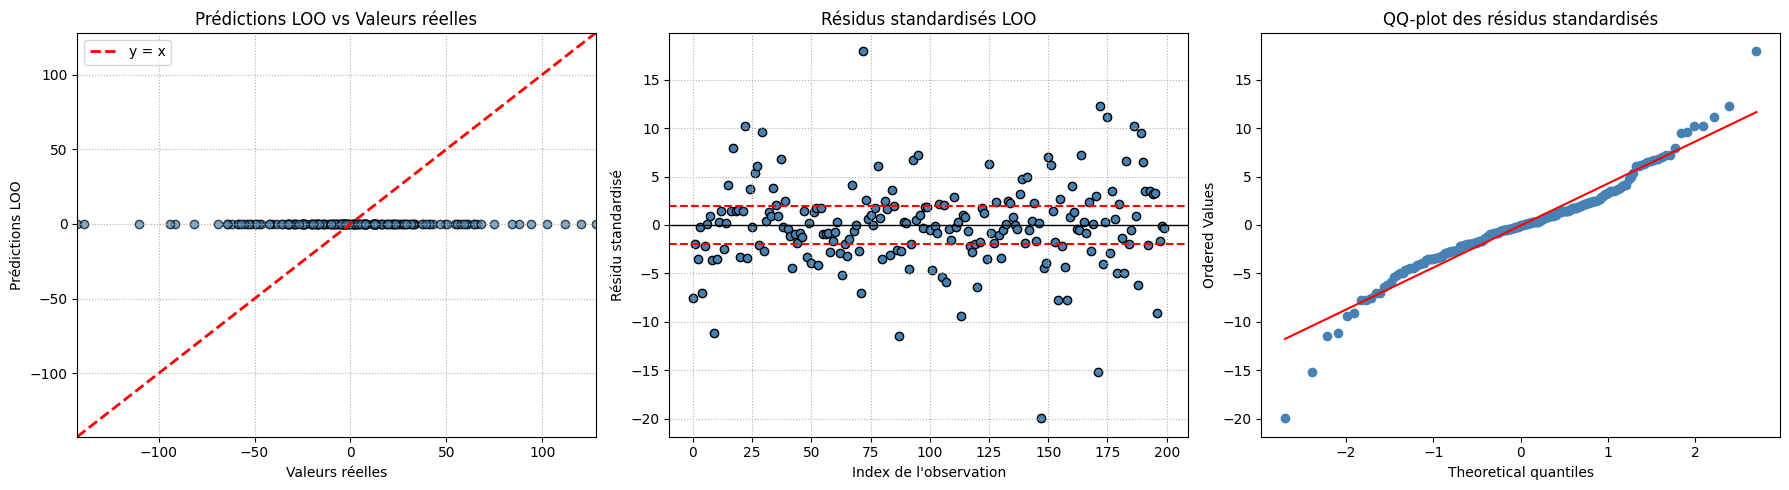

taille du vecteur de Y_test_reconstruct: (1000, 4096)


In [46]:
n_pc = 5 #nombre composantes principales
theta = 3
sigma = 1
Y_test_reconstruct_ACP = mfs.ACP(x_train,x_test,y_train,n_pc,[theta,sigma]) 

## Méthode par B-Splines

vecteur de noeuds [-90 -90 -80 -70 -60 -50 -40 -30 -20 -10   0  10  20  30  40  50  60  70
  80  90  90  90]
taille du vecteur de y_train: (200, 4096)
taille de la base B-spline : 400
(200, 5)
Variance expliquée par les 5 premières composantes : [0.77399615 0.13928855 0.03053799 0.01860059 0.01634105]
Variance globale expliquée : 0.9787643261966475
Taille du jeu d'entrainement transformé par ACP : (200, 5)
Affichage des hyperparamètres optimisés

--- Composante principale 1 ---
╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                 │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════════════╡
│ GPR.mean_function.c                │ Parameter │ Identity         │         │ True        │ (1,)    │

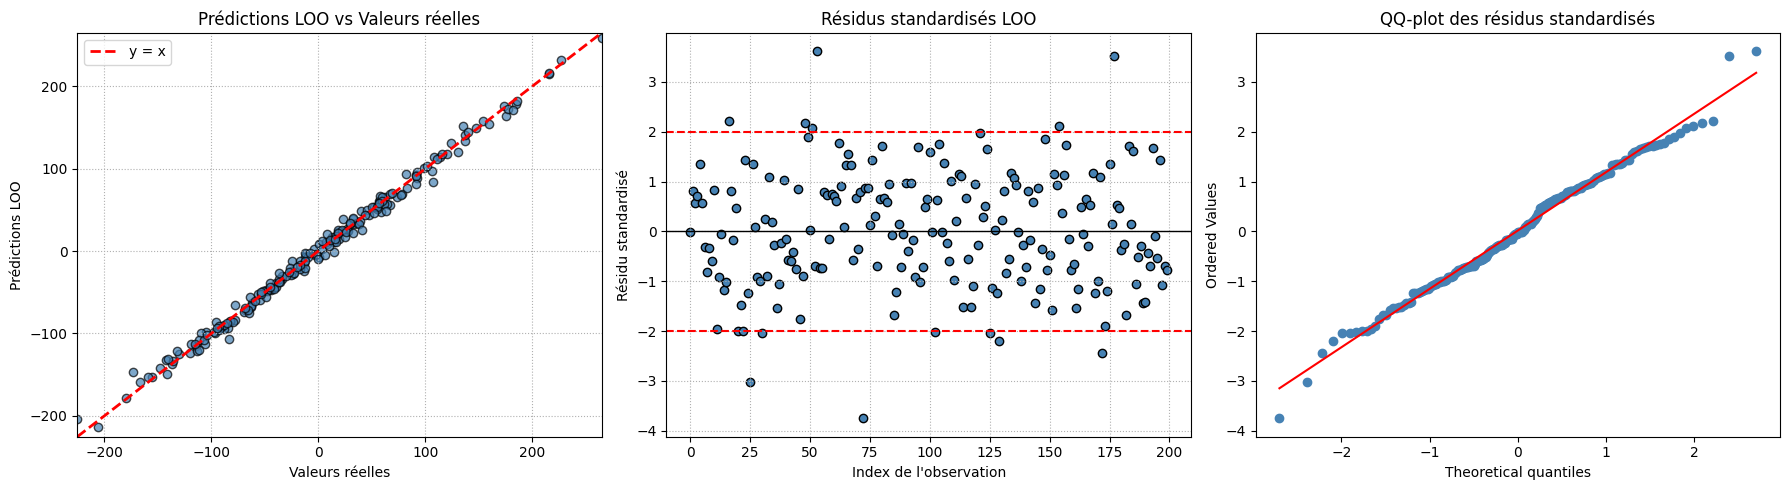

Affichage des hyperparamètres optimisés

--- Composante principale 2 ---
╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                 │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════════════╡
│ GPR.mean_function.c                │ Parameter │ Identity         │         │ True        │ (1,)    │ float64 │ [9.85063]             │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────────┤
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 3138.37264            │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼──────

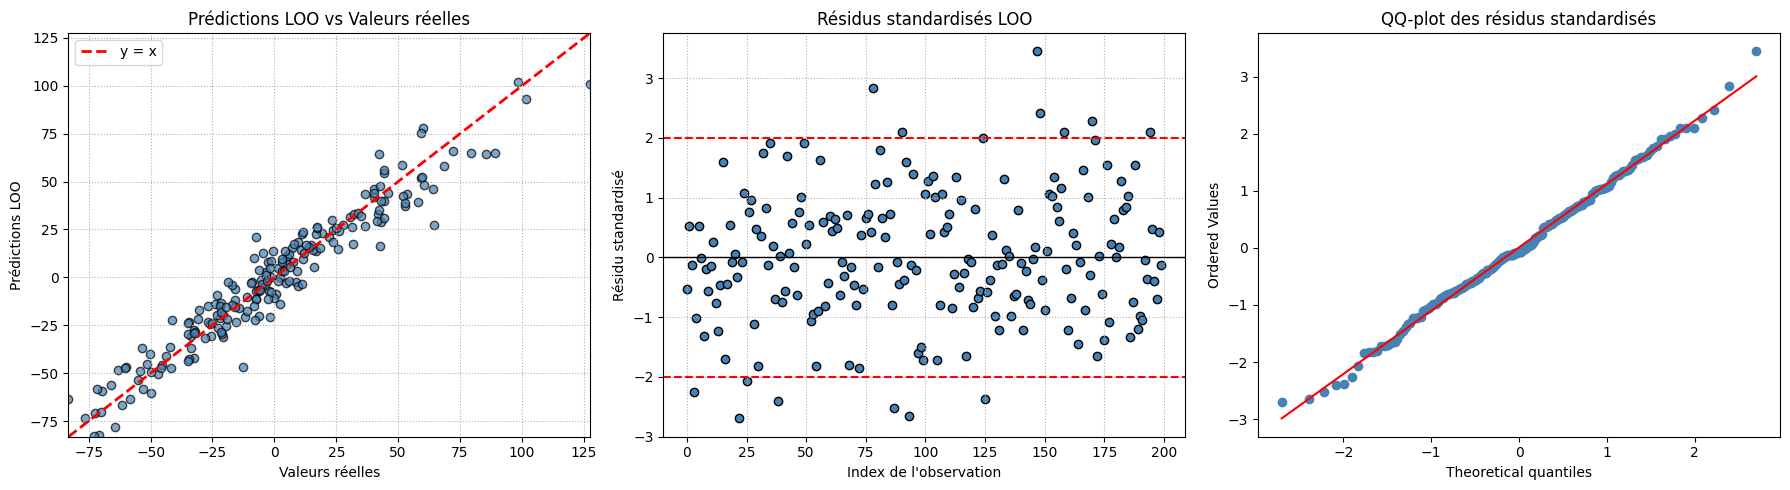

Affichage des hyperparamètres optimisés

--- Composante principale 3 ---
╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                  │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════════════╡
│ GPR.mean_function.c                │ Parameter │ Identity         │         │ True        │ (1,)    │ float64 │ [1.4456]               │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────┤
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 304.82152              │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼

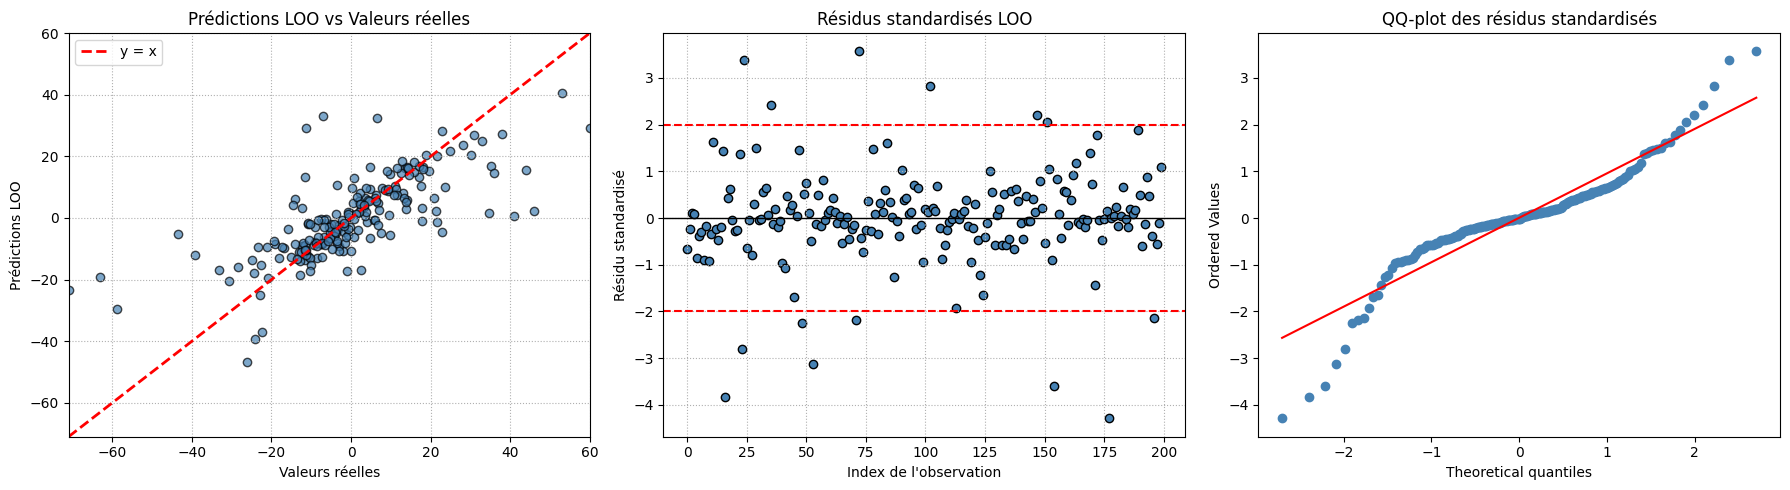

Affichage des hyperparamètres optimisés

--- Composante principale 4 ---
╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════════════╡
│ GPR.mean_function.c                │ Parameter │ Identity         │         │ True        │ (1,)    │ float64 │ [-1.57548]           │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────────────┤
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 246.61154            │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼──

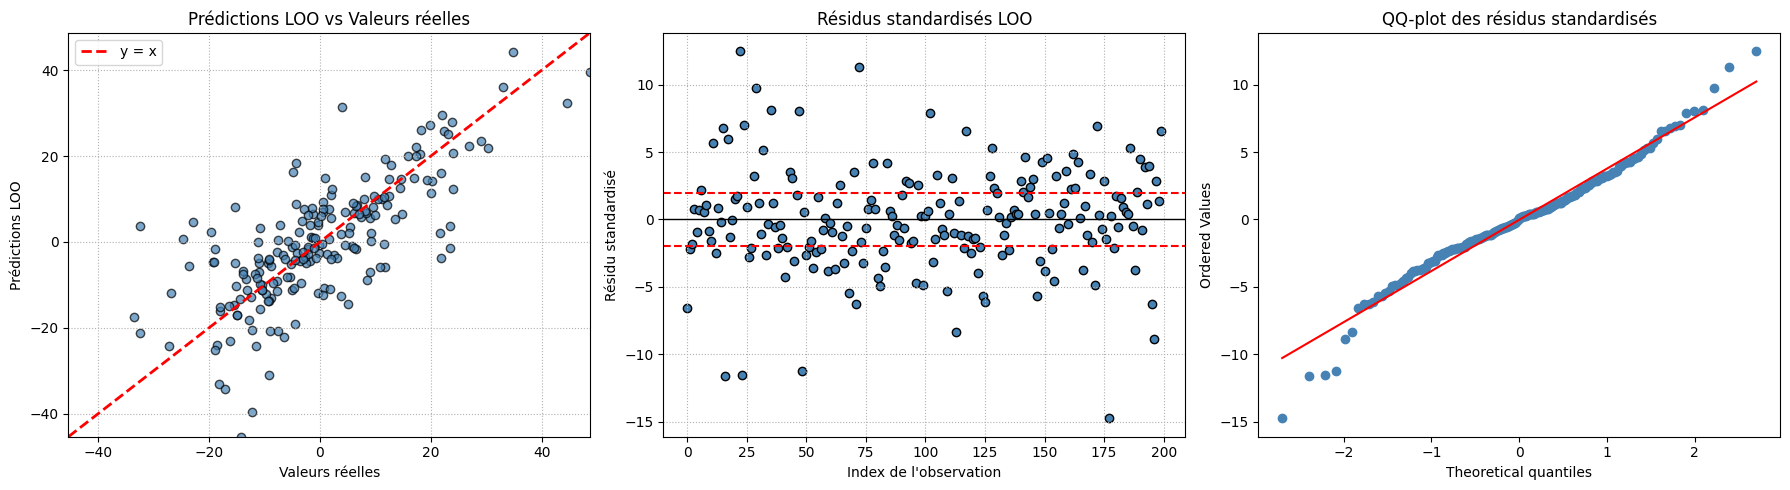

Affichage des hyperparamètres optimisés

--- Composante principale 5 ---
╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════════════╡
│ GPR.mean_function.c                │ Parameter │ Identity         │         │ True        │ (1,)    │ float64 │ [-1.58746]           │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────────────┤
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 152.13649            │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼──

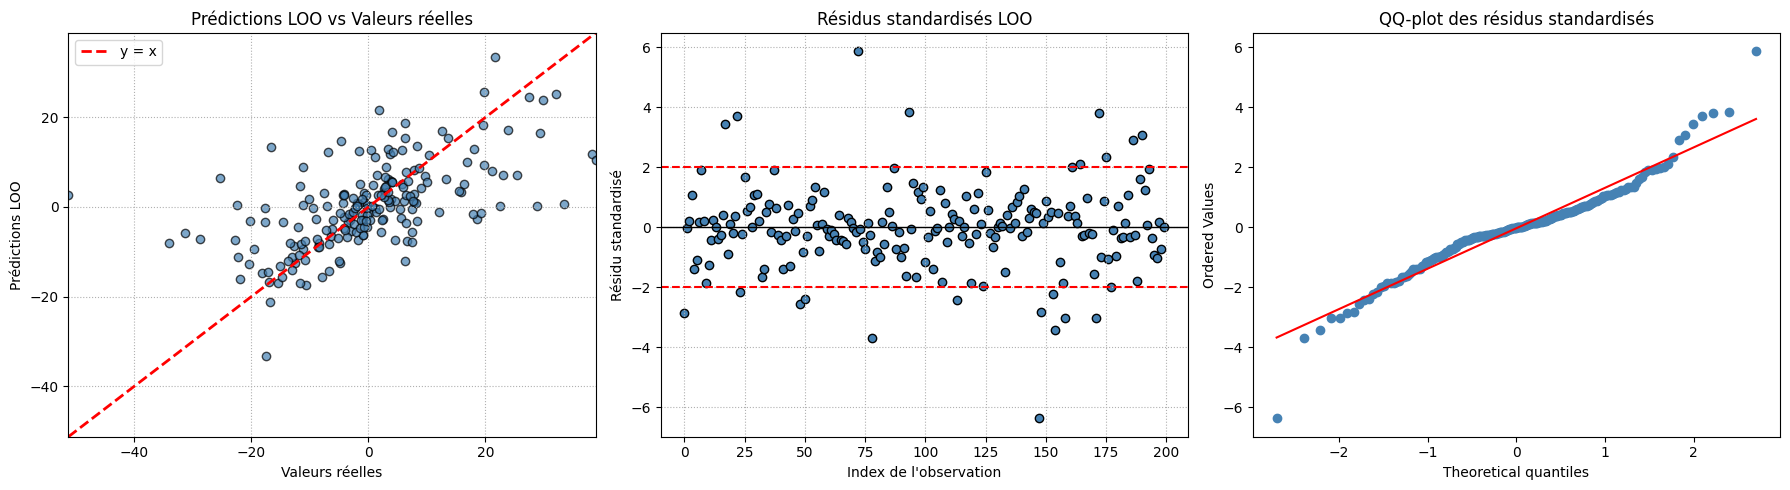

taille du vecteur de Y_test_reconstruct: (1000, 400)
taille du vecteur de C_reconstruct: (1000, 400)
taille du vecteur de Y_test_reconstruct: (1000, 4096)


In [47]:
t1 = np.concatenate((
    np.repeat(-90, 2),
    np.arange(-80, 91, 10),
    np.repeat( 90, 2)
))
print("vecteur de noeuds",t1)
Y_test_reconstruct_Bsplines = mfs.Bsplines_ACP(x_train, x_test, y_train,t1, t1, n_pc, [theta,sigma], degree=1)

## Méthode par Ondelettes

Nombre de coefficients conservés pour l'ACP : 1614
(200, 5)
Variance expliquée par les 5 premières composantes : [0.775443   0.13512183 0.03266043 0.01951721 0.01679912]
Variance globale expliquée : 0.9795415923026591
Taille du jeu d'entrainement transformé par ACP : (200, 5)
Affichage des hyperparamètres optimisés

--- Composante principale 1 ---
╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                  │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════════════╡
│ GPR.mean_function.c                │ Parameter │ Identity         │         │ True        │ (1,)    │ float64 │ [151.05129]            │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─

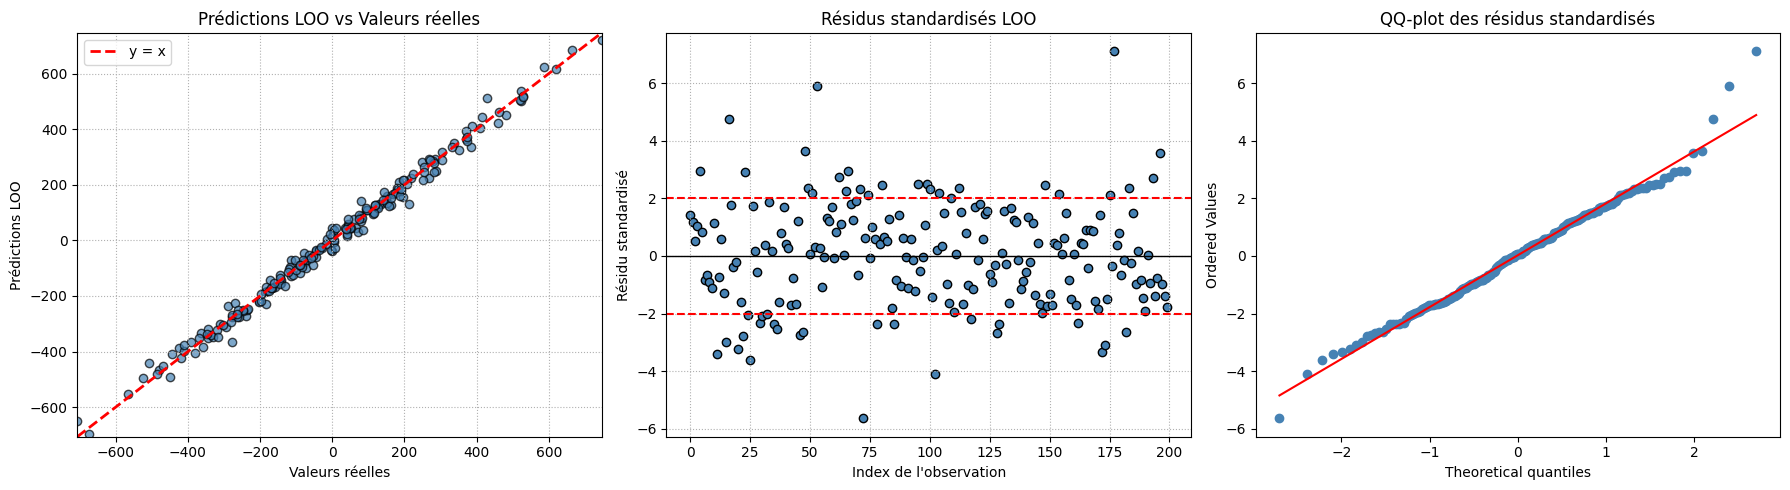

Affichage des hyperparamètres optimisés

--- Composante principale 2 ---
╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                 │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════════════╡
│ GPR.mean_function.c                │ Parameter │ Identity         │         │ True        │ (1,)    │ float64 │ [10.50317]            │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────────┤
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 122.95781             │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼──────

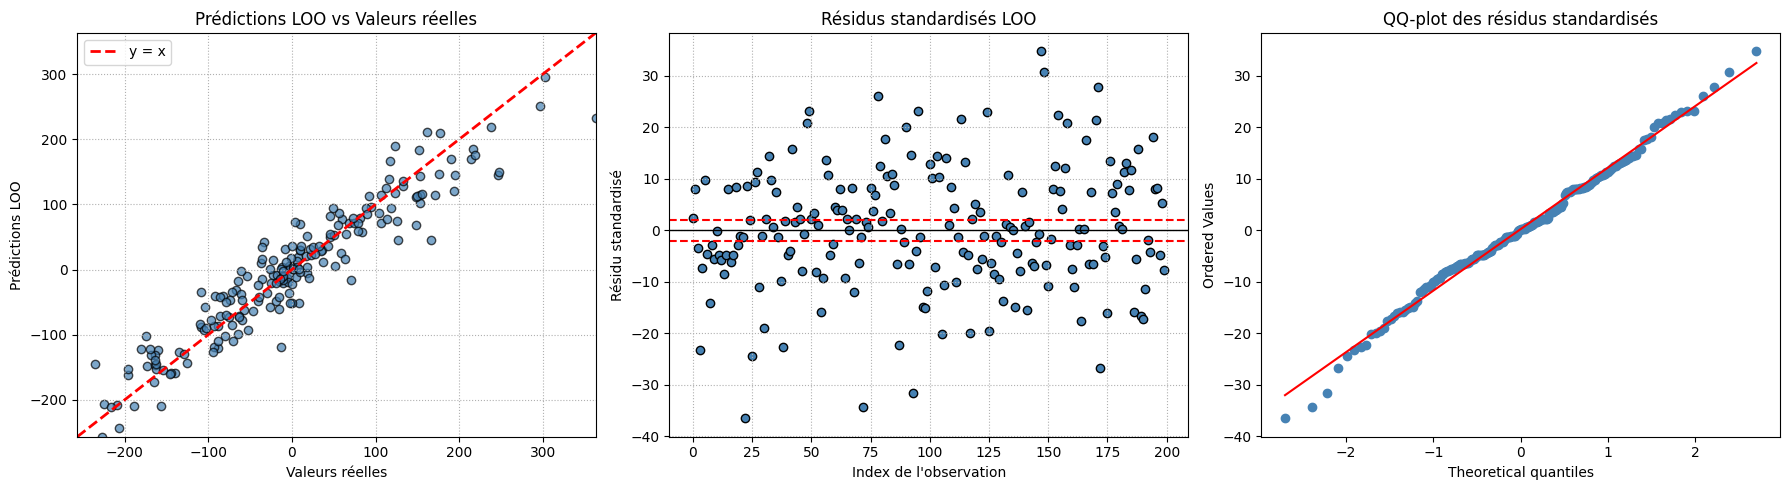

Affichage des hyperparamètres optimisés

--- Composante principale 3 ---
╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                  │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════════════╡
│ GPR.mean_function.c                │ Parameter │ Identity         │         │ True        │ (1,)    │ float64 │ [11.34198]             │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────┤
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1405.74656             │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼

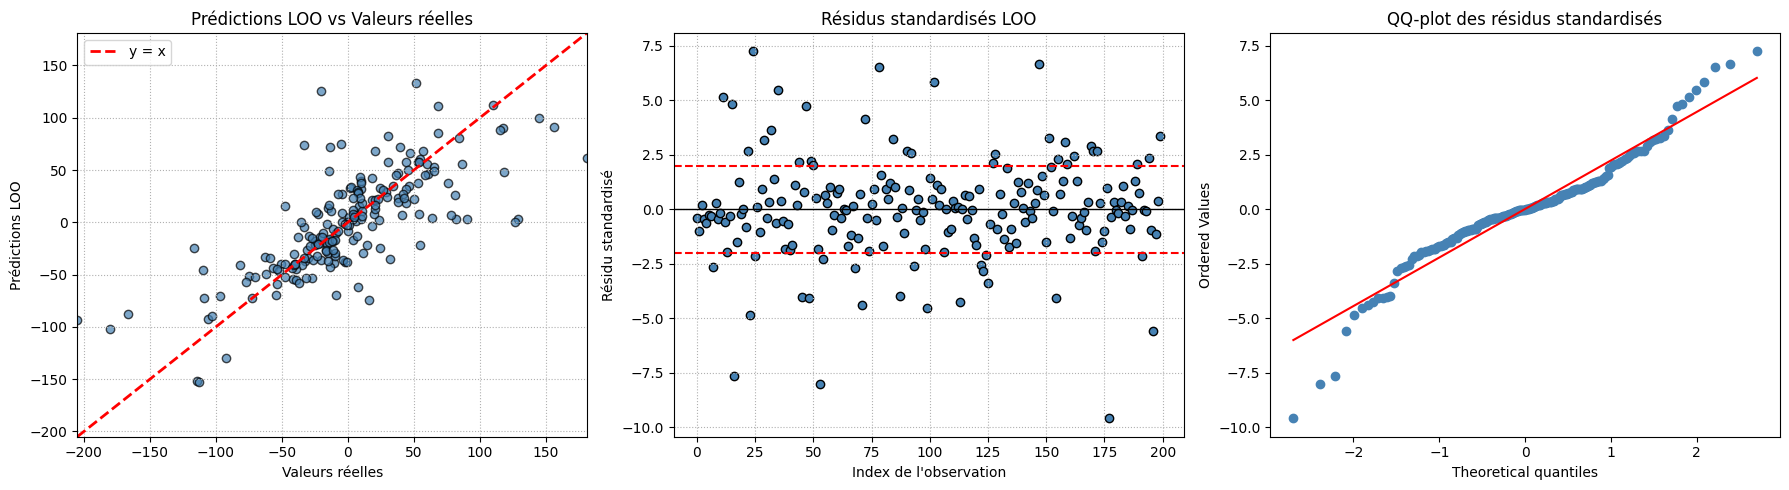

Affichage des hyperparamètres optimisés

--- Composante principale 4 ---
╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                 │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════════════╡
│ GPR.mean_function.c                │ Parameter │ Identity         │         │ True        │ (1,)    │ float64 │ [1.48652]             │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────────┤
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 2418.29197            │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼──────

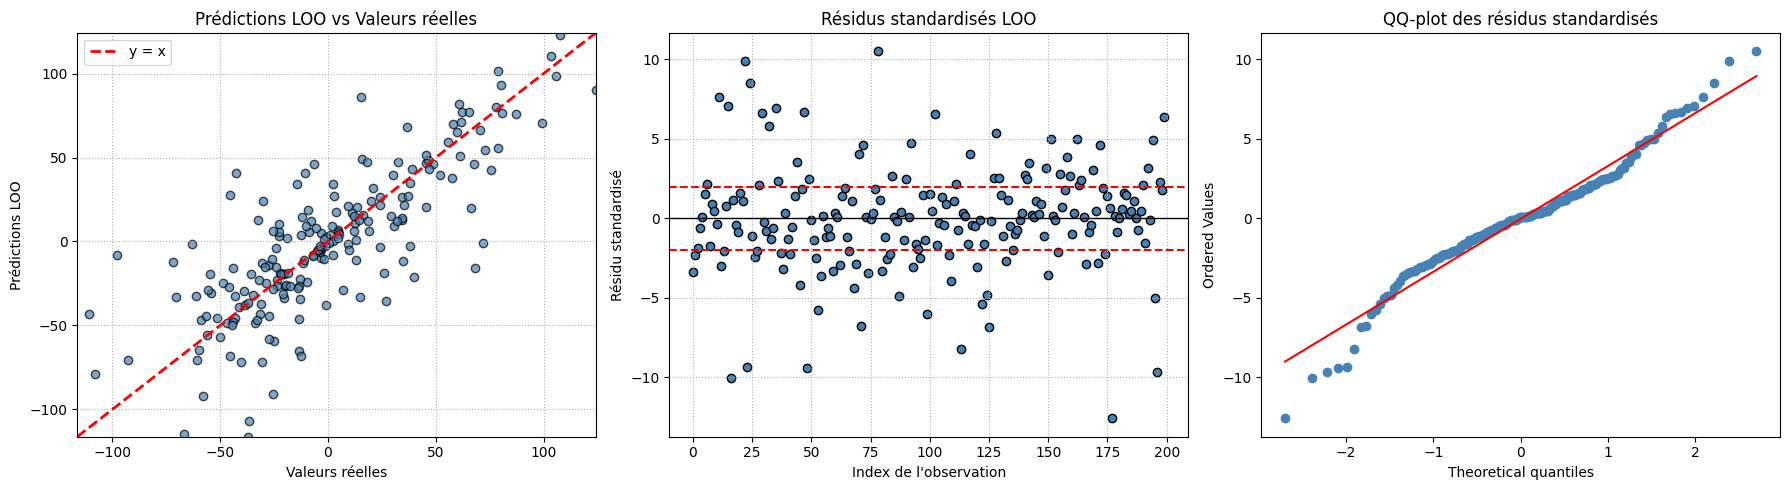

Affichage des hyperparamètres optimisés

--- Composante principale 5 ---
╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                  │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════════════╡
│ GPR.mean_function.c                │ Parameter │ Identity         │         │ True        │ (1,)    │ float64 │ [0.01345424]           │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────┤
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 83.75143               │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼

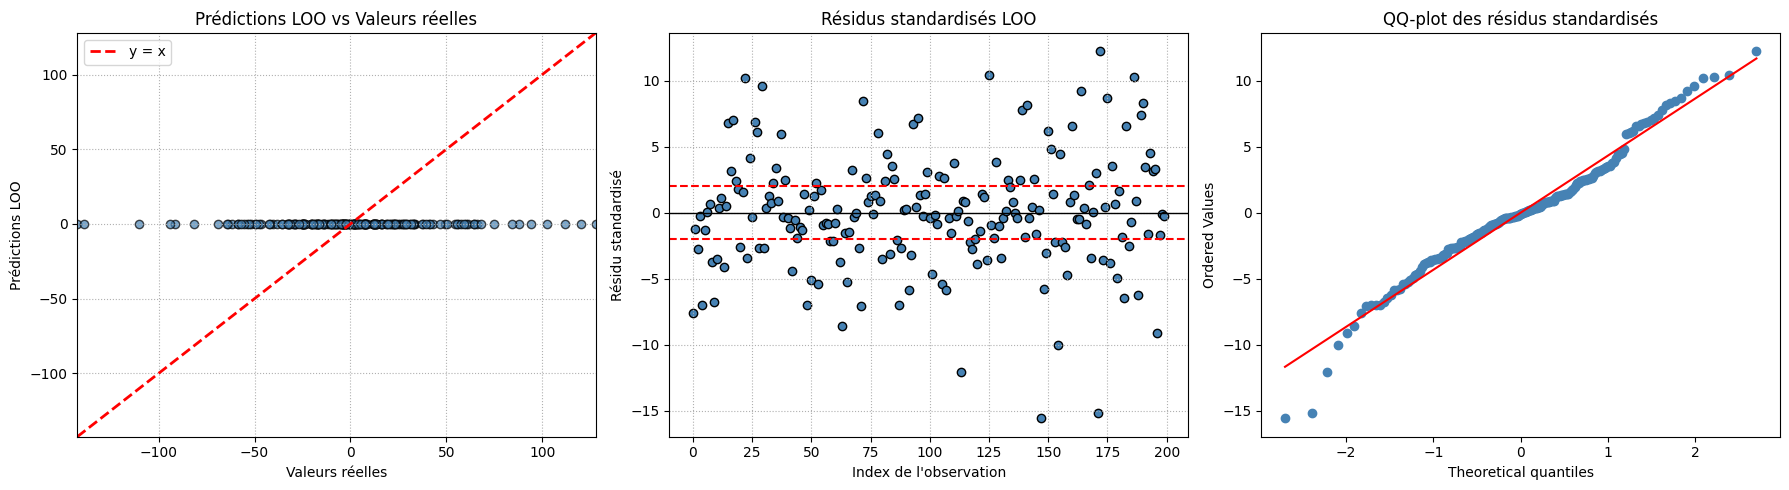

taille du vecteur de Y_test_reconstruct: (1000, 1615)


In [48]:
n_pc = 5 #nombre composantes principales
K_tilde = 1200
#Il faut mettre un p quasiment égal à 1 pour obtenir un résultat satisfaisant
p = 0.99999
Y_test_reconstruct_wavelet = mfs.ACPF_Ondelettes(x_train,x_test,y_train,n_pc,[theta,sigma],K_tilde=0,p=p,J=3)